In [1]:
DATA_LOCATION = "/work/mk423/Anxiety/"
UMC_PATH = "/hpc/home/mk423/Anxiety/Universal-Mouse-Code/"
MODEL_PATH = "../Models/"
data_file = "C19_Data.pkl"

FEATURE_LIST = ['X_psd','X_coh','X_gc']
FEATURE_VECTOR = FEATURE_LIST
FEATURE_WEIGHT = [10,1,1]

MT_MODEL_PATH = MODEL_PATH + "Positive_MT_10_res_loss_10_power_features.pt"
PROJECTION_SAVE_PATH = "/hpc/home/mk423/Anxiety/MultiTaskWork/Projections/holdoutExperiments/"

TRAIN = False
PROJ_TEST = True

In [2]:
import pickle
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
import sys
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
sys.path.append(UMC_PATH)
sys.path.append(PROJECTION_SAVE_PATH)
#from dCSFA_model import dCSFA_model
import umc_data_tools as umc_dt
from dCSFA_NMF import dCSFA_NMF

if torch.cuda.is_available():
    device="cuda:0"
else:
    device="cpu"


print("Using device: %s"%(device))

#For Consistency
RANDOM_STATE=42

import pandas as pd

model = torch.load(MT_MODEL_PATH,map_location='cpu')
model.device = "cpu"
model.eval()

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda:0


dCSFA_NMF(
  (recon_loss_f): MSELoss()
  (Encoder): Sequential(
    (0): Linear(in_features=5152, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=256, out_features=20, bias=True)
    (4): Softplus(beta=1, threshold=20)
  )
)

In [7]:
dataDict = pickle.load(open(DATA_LOCATION + data_file,"rb"))

X = np.hstack([weight*dataDict[feature] for weight,feature in zip(FEATURE_WEIGHT,FEATURE_LIST)])
y_time = dataDict['y_time']
y_mouse = np.array(dataDict['y_mouse'])
y_condition = np.array(dataDict['y_condition'])
y_task = dataDict['y_task']
y_expDate = dataDict['y_expDate']
y_sex = np.array(dataDict['y_sex'])

y_pred,s = model.transform(X,None)[2:]

#Get per mouse average scores, average scores in HC and average scores in EPM
mouse_list = []
avg_score_list = []
avg_hc_score_list = []
avg_task_score_list = []
condition_list = []
for mouse in np.unique(y_mouse):
    mouse_mask = y_mouse==mouse
    hc_mouse_mask = np.logical_and(mouse_mask,y_task==0)
    task_mouse_mask = np.logical_and(mouse_mask,y_task==1)
    avg_score = np.mean(s[mouse_mask==1,0])
    avg_score_hc = np.mean(s[hc_mouse_mask==1,0])
    avg_score_task = np.mean(s[task_mouse_mask==1,0])
    
    mouse_list.append(mouse)
    avg_score_list.append(avg_score)
    avg_hc_score_list.append(avg_score_hc)
    avg_task_score_list.append(avg_score_task)
    condition_list.append(np.unique(y_condition[y_mouse==mouse])[0])
    
proj_dict = {
    "mouse":mouse_list,
    "condition":condition_list,
    "avgScore":avg_score_list,
    "avgHCScore":avg_hc_score_list,
    "avgTaskScore":avg_task_score_list
}
df_projections = pd.DataFrame.from_dict(proj_dict)

df_projections.to_csv(PROJECTION_SAVE_PATH + "C19_mean_scores.csv")

In [4]:
wild_type_mask = (np.array(y_condition)=="WT").astype(float)
sex_mask = y_sex=="M"
task_mask = y_task


mw_auc_dict = umc_dt.lpne_auc(y_pred,y_task.squeeze(),y_mouse,s,True)
mw_mean, mw_std = umc_dt.get_mean_std_err_auc(y_pred,y_task.squeeze(),y_mouse,s,True)
print("by mouse hc vs task auc: {:.3} +/- {:.3}".format(mw_mean,mw_std))

mw_auc_dict = umc_dt.lpne_auc(y_pred[wild_type_mask==1],y_task[wild_type_mask==1].squeeze(),y_mouse[wild_type_mask==1],s[wild_type_mask==1],True)
mw_mean, mw_std = umc_dt.get_mean_std_err_auc(y_pred[wild_type_mask==1],y_task[wild_type_mask==1].squeeze(),y_mouse[wild_type_mask==1],s[wild_type_mask==1],True)
print("by wildtype mouse hc vs task auc: {:.3} +/- {:.3}".format(mw_mean,mw_std))

mw_auc_dict = umc_dt.lpne_auc(y_pred[wild_type_mask==0],y_task[wild_type_mask==0].squeeze(),y_mouse[wild_type_mask==0],s[wild_type_mask==0],True)
mw_mean, mw_std = umc_dt.get_mean_std_err_auc(y_pred[wild_type_mask==0],y_task[wild_type_mask==0].squeeze(),y_mouse[wild_type_mask==0],s[wild_type_mask==0],True)
print("by clock-19 mouse hc vs task auc: {:.3} +/- {:.3}".format(mw_mean,mw_std))

mw_auc_dict = umc_dt.lpne_auc(y_pred[sex_mask==0],y_task[sex_mask==0].squeeze(),y_mouse[sex_mask==0],s[sex_mask==0],True)
mw_mean, mw_std = umc_dt.get_mean_std_err_auc(y_pred[sex_mask==0],y_task[sex_mask==0].squeeze(),y_mouse[sex_mask==0],s[sex_mask==0],True)
print("by Female mouse hc vs task auc: {:.3} +/- {:.3}".format(mw_mean,mw_std))

mw_auc_dict = umc_dt.lpne_auc(y_pred[sex_mask==1],y_task[sex_mask==1].squeeze(),y_mouse[sex_mask==1],s[sex_mask==1],True)
mw_mean, mw_std = umc_dt.get_mean_std_err_auc(y_pred[sex_mask==1],y_task[sex_mask==1].squeeze(),y_mouse[sex_mask==1],s[sex_mask==1],True)
print("by Male mouse hc vs task auc: {:.3} +/- {:.3}".format(mw_mean,mw_std))

by mouse hc vs task auc: 0.629 +/- 0.0246
by wildtype mouse hc vs task auc: 0.65 +/- 0.0302
by clock-19 mouse hc vs task auc: 0.611 +/- 0.0386
by Female mouse hc vs task auc: 0.686 +/- 0.0405
by Male mouse hc vs task auc: 0.579 +/- 0.0183


In [5]:
mw_auc_dict = umc_dt.lpne_auc(y_pred,y_task.squeeze(),y_mouse,s,True)
mw_mean, mw_std = umc_dt.get_mean_std_err_auc(y_pred,y_task.squeeze(),y_mouse,s,True)
print("by mouse hc vs task auc: {:.3} +/- {:.3}".format(mw_mean,mw_std))

auc_list = []
p_val_list = []

for mouse in y_mouse:
    auc_list.append(mw_auc_dict[mouse][0])
    p_val_list.append(mw_auc_dict[mouse][1])

saveDict = {
    "mouse":y_mouse,
    "sex":y_sex,
    "condition":y_condition,
    "in-task":y_task,
    "time":y_time,
    "expDate":y_expDate,
    "scores":s[:,0],
    "hc vs task auc": auc_list,
    "hc vs task pval": p_val_list,
    
}

df = pd.DataFrame.from_dict(saveDict)
df.to_csv(PROJECTION_SAVE_PATH + "MT_onto_CLK-19_EPM.csv")

by mouse hc vs task auc: 0.629 +/- 0.0246


In [89]:
roc_auc_score((np.array(y_condition)=="CLOCK").astype(float)[y_task==0],y_pred[y_task==0])

0.4667825728886914

In [75]:
wild_type_mask = (np.array(y_condition)=="WT").astype(float)
task_mask = y_task

print("Wild Type HC vs Task:",roc_auc_score(task_mask[wild_type_mask==1],y_pred[wild_type_mask==1]))

Wild Type HC vs Task: 0.6573685997893017


In [74]:
print("Clock Mice HC vs Task:",roc_auc_score(task_mask[wild_type_mask==0],y_pred[wild_type_mask==0]))

Clock Mice HC vs Task: 0.617495384502002


In [38]:
roc_auc_score(y_task,y_pred)

0.6404977392009688

In [41]:
np.array(y_condition)=="CLK"

array([False, False, False, ..., False, False, False])

In [76]:
df_projections.head()

,mouse,avgScore,avgHCScore,avgTaskScore
0,Mouse0911,0.063547,0.064684,0.062216
1,Mouse0912,0.071724,0.070832,0.072075
2,Mouse0913,0.067201,0.071164,0.065972
3,Mouse0914,0.067377,0.070309,0.066531
4,Mouse2401,0.067612,0.067482,0.067702


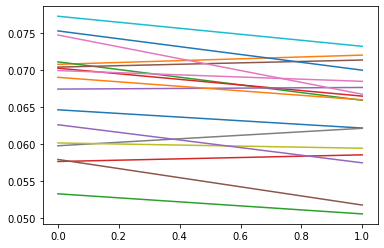

In [69]:
import matplotlib.pyplot as plt
plt.plot(df_projections.values[:,2:].T)
plt.show()

In [67]:
df_projections.values[:,2:]

array([[0.06468416005373001, 0.062216393649578094],
       [0.07083234935998917, 0.07207459956407547],
       [0.07116377353668213, 0.06597200781106949],
       [0.07030855864286423, 0.06653071939945221],
       [0.06748200207948685, 0.06770232319831848],
       [0.0704551562666893, 0.071412093937397],
       [0.06998889148235321, 0.06853090971708298],
       [0.05982178449630737, 0.06218354031443596],
       [0.060201797634363174, 0.0594886913895607],
       [0.07732944935560226, 0.07326607406139374],
       [0.07534714043140411, 0.07004065811634064],
       [0.06907346099615097, 0.06603098660707474],
       [0.05332735553383827, 0.05061051994562149],
       [0.05769411474466324, 0.0585951954126358],
       [0.06266482919454575, 0.057514168322086334],
       [0.0579715259373188, 0.05180870741605759],
       [0.0747944638133049, 0.06679071485996246]], dtype=object)

/hpc/home/mk423/Anxiety/MultiTaskWork/Code
